# Configuration and parameterization tutorial

This notebook outlines the steps required to generate the files used to configure the [vadose](../docs/_build/html/vadoseZone.html), [groundwater](../docs/_build/html/groundwaterZone.html), and [channel](../docs/_build/html/channel.html) zones associated with each [REW](../docs/_build/html/REW.html).

In [1]:
%matplotlib inline
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import os
import sys
from os.path import dirname
import pickle
import gdal
import fiona
import glob
import shapely
import pandas as pd
from shapely import geometry,ops
import numpy as np
import fiona
import shapely
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import geopandas as gp
import seaborn
import pyproj
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
from vadoseZone import LaioVadoseZone, PorporatoVadoseZone
from groundwaterZone import GroundwaterZone, NonlinearReservoir, NonlinearReservoir, TwoLinearReservoir, TwoParallelLinearReservoir

This tutorial assumes that an REW network has previously been extracted using the network extraction GRASS tool provided in the data preparation folder. Instructions for running this tool can be found in the [GRASS GIS tutorial](). 

Three python files are used for model configuration and parameterization, all of which can be found in the `1_data_preparation` directory of the model folder. 

##  1. Prepare model configuration - `model_config`

This configuration script can be edited to change the particulars of models' numerical solvers, as well as the start and stop dates for running the model. Simply run the script to write the configuration data to a file. 

In [2]:
from prep import model_config
model_config()
model_config = pickle.load(open( os.path.join(parent_dir,'model_data','model_config.p'), "rb" ) )
print model_config.keys()

['resample_freq_hillslope', 'dt_hillslope', 'spinup_date', 'Tmax', 'resample_freq_channel', 't_hillslope', 'stop_date', 'timestamps_channel', 'dt_channel', 't_channel', 'timestamps_hillslope', 'start_date']


Keys of the model configuration dictionary include:
* `start_date` (datetime instance): Start date for running model
* `stop_date` (datetime instance): Stop date for running model
* `spinup_date` (datetime instance): Date after which model has spun up. Only calibrate model after this date.
* `Tmax` (float): Number of days of simulation
* `dt_hillslope` (float): Hillslope simulation timestep in days
* `dt_channel` (float): Channel simulation timestep in days
* `resample_freq_hillslope` (float): Frequency at which to resample forcing data depending on timestep to solve the hillslope model
* `resample_freq_channel` (float): Frequency at which to resample forcing data depending on timestep to solve the channel model
* `timestamps_hillslope` (datetimes): Times at which to simulate hillslope dynamics
* `timestamps_channel` (datetimes): Times at which to simulate channel dynamics

To change any of these model configuration variables, use your favorite text editor to alter their values in the `prep_model_config.py` file, then re-run the script. 

There are some restrictions on allowable values of these configuration variables. All model time units are expressed in days, and the minimum model timestep is one minute, therefore, `dt_hillslope` and `dt_channel` must be greater than or equal to $\frac{1}{1440}$ days. 

The `spinup_date` is a user specified date after which initial model solution transients can be considered negligible. This date is important for calibration, as the model is only calibrated using model generated data after `spinup_date`. The model itself, however, is run from `start_date` to `stop_date`.

In [3]:
print("\nModel run start date is: %s \nModel is spun up after: %s \nModel run end date is: %s" % (str(model_config['start_date']), str(model_config['spinup_date']), str(model_config['stop_date'])))


Model run start date is: 2012-07-01 
Model is spun up after: 2013-07-01 
Model run end date is: 2014-12-30


## 2. Scraping REW Topology and Geometry - `rew_config.py`

This python script converts GIS data related to stream network topology and physical characteristics (see [GRASS GIS tutorial]()) into a Pandas dataframe that is written to `rew_config.p` in the `model_data directory`. 



Fetching REW configuration data...
REW IDs used: [2, 4, 6, 8, 10]
Corresponding basin IDs: [2, 4, 6, 8, 10]
REW IDs and basin IDs match!
Total number of REW IDs used: 5
Total number of unique REW group(s): 1

Watershed with REW sub-basins. 
All stream network information is stored in rew_config.p.
e.g., streams 10 and 4 feed into stream 2.


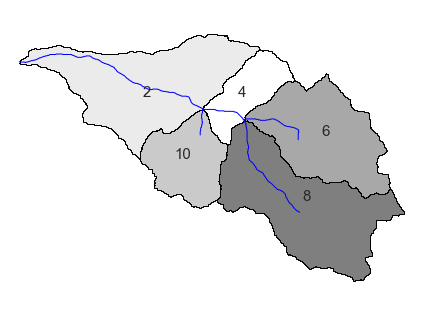

In [4]:
from prep import rew_config
rew_config()
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )

basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins)
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]

ax1 = basins_shape.plot()
for idx, row in basins_shape.iterrows():
    plt.annotate(s=row['cat'], xy=row['coords'],
                 horizontalalignment='center',fontsize=15)

streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
streams_shape = gp.GeoDataFrame.from_file(streams)
streams_shape.plot(ax=ax1,color='blue')

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.patch.set_facecolor('white')
prev_str01 = str(int(rew_config[2]['prev_str01']))
prev_str02 = str(int(rew_config[2]['prev_str02']))
title_str = 'Watershed with REW sub-basins. \n'
title_str += 'All stream network information is stored in rew_config.p.\n'
title_str += ("e.g., streams %s and %s feed into stream %s." % (prev_str01,prev_str02,'2'))
print title_str

## 3. Parameterize the Model - `rew_params`

### - The parameter list

This final script writes into `model_data` the parameter set for each REW [channel](../docs/_build/html/channel.html) instance, as well as for each unique REW *group*. A REW *group* is a collection of REWs which share physiographic and climatic features and are thus parameterized and forced with identical data. This decreases the computational demand of the model due to the fact that the vadose and groundwater zone models only need to be run once for each REW group, as opposed to once for each REW. 

In [5]:
from prep import rew_params
rew_params()

channel_params = pickle.load(  open( os.path.join(parent_dir,'model_data','channel_params.p'), "rb" ) )
group_params = pickle.load(  open( os.path.join(parent_dir,'model_data','group_params.p'), "rb" ) )

group_number = group_params.keys()[0]
len_group = len(group_params[group_number])
param_list = [param for param in group_params[0].keys()]
print_str = "\nGroup " + str(group_number) + " requires specification of the following parameters/variables: \n"
print_str += ", ".join(param_list)
print print_str


Group 0.0 requires specification of the following parameters/variables: 
a, b, emax, storage, gz, n, leakage, sw, groundwater, ET, discharge, vz, sfc, zr


### - Model structure for each group

In addition to model parameterization, model structure can be changed between REW groups. For each group in the `group_params` dictionary, classes for both the vadose zone model (dictionary key `vz`) and the groundwater zone model (dictionary key `gz`) must be specified. In this way, groundwater and vadose zone representations can vary across the landscape.

In [6]:
vz = str(group_params[group_number]['vz'])
gz = str(group_params[group_number]['gz'])
print_str = "\nGroup " + str(group_number) + " consists of a " + vz + " vadose zone model \n"
print_str += "and a " + gz + " groundwater zone model."
print print_str


Group 0.0 consists of a vadoseZone.PorporatoVadoseZone vadose zone model 
and a groundwaterZone.NonlinearReservoir groundwater zone model.




### - Specify parameter ranges

To facilitate model calibration, realistic parameter ranges can optionally be specified in the `prep_rew_params.py` script using the `param_ranges` dictionary. Only parameters with specified ranges will be calibrated, others will remain set to the initial value specified in `group_params` or `channel_params`. 

In [7]:
param_ranges = pickle.load(  open( os.path.join(parent_dir,'model_data','param_ranges.p'), "rb" ) )
param_name = param_ranges[group_number].keys()[0]
param_range = param_ranges[group_number].values()[0]
print_str = "\nParameter " + param_name + " from group " + str(group_number) + " will be sampled from the interval " + str(param_range)
print print_str


Parameter a from group 0.0 will be sampled from the interval (0.0001, 0.01)
